In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
plt.style.use('classic')
%matplotlib inline

In [7]:
# Model parameters
parameters=pd.Series(dtype='float64')
parameters['β']=0.98 # discount rate : standard
parameters['γ']=2 # risk aversion : standard
parameters['η']=0.83 # Elasticity of substitution (tradable vs nontradable) : conservative (Bianchi,2011)
parameters['ξ']=1.5 # Elasticity of substitution (domestic tradable vs import) : standard 
parameters['σ']=6 # Elasticity of substitution (differentiated varieties) : standard
parameters['ν']=0.047 # bond adjustment cost : target 10% of GDP in ss
#parameters['P_T']=1 # tradable price index (numeraire)
parameters['P_TI']=1# import price index (exogenous numeraire) 
parameters['ω']=0.5 # weight on tradables : target 50% tradable share in consumption (Lombardo and Ravenna, 2012)
#parameters['L']=1 # labor supply

parameters['k']=1/1.67+parameters['σ']-1  # shape parameter of Pareto : target 1.67 log US plant sales sd
parameters['a_min']=1 # lower bound of Pareto

parameters['μ']=0.6 # foreign input share of export fixed cost (Chaney 2016, 0.5~0.7)
parameters['F_x']=0.0034 # export fixed cost : target 21% exporting firms in US
parameters['F_e']=1 # entry cost
parameters['ψ']=0.025 # probability of firm exit : US data, 10 percent job destruction per year)
parameters['κ']=0.1 # development of financial market (benchmark=1)
parameters['τ']=1.3 # iceberg trade cost : standard (Obstfeld and Rogoff, 2001)

parameters['Ε']=1 # Nominal exchange rate
parameters['P_star']=1 # foreign price index
parameters['w_star']=10 # foreign wage : arbitrary
parameters['W_star']=11 # foreign nominal wage
parameters['r_star']=0.04 # foreign bond return : standard
parameters['A_star']=1 # foreign technology
#parameters['P_T_star']=1 # foreign tradable price index
#parameters['P_TI_star']=5 # foreign imported tradable price index
#parameters['E_star']=200 # foreign consumption expenditure

parameters['ρ_A']=0.906 # technology AR(1) coefficient (BKK, 1992)
parameters['σ_A']=0.00852 # technology standard deviation (BKK, 1992)
parameters['ρ_P_star']=0.906 # technology AR(1) coefficient (BKK, 1992)
parameters['σ_P_star']=0.00852 # technology standard deviation (BKK, 1992)
parameters['ρ_A_star']=0.906 # technology AR(1) coefficient (BKK, 1992)
parameters['σ_A_star']=0.00852 # technology standard deviation (BKK, 1992)

parameters['Y_N']=10 # nontradable endowment :arbitrary
parameters['q_f_res']=5 # foreign demand
parameters['q_f_res_star']=5  #q_f_res=(parameters.P_star**(parameters.σ-1))*parameters.q_f_res
# parameters['w']=5 # wage
# parameters['M_d']=1

parameters['ρ']=21 # weight on labor (Correia, Neves, Rebelo, 1995)
parameters['λ']=1 # Frisch elasticity of labor supply (GHH, CNR)

In [8]:
def G(a):
    m=1-(parameters.a_min/a)**parameters.k
    if m<0:
        return 0
    else:
        return m

def equilibrium_equations(variables_forward, variables_current, parameters):
    # parameters
    p=parameters
    
    # Pareto    
    θ=(p.k/(p.k-(p.σ-1)))**(1/(p.σ-1))     #parameters.a_min*(parameters.k/(parameters.k-(parameters.σ-1)))**(parameters.σ/(parameters.σ-1))
    a_tilde_d=θ*p.a_min
    
    # variables
    fwd=variables_forward
    cur=variables_current
    
    C_N=p.Y_N
    
    # Tradable price definition
    cur_P_T=(p.P_TI**(1-p.ξ)+cur.P_TD**(1-p.ξ))**(1/(1-p.ξ))
    fwd_P_T=(p.P_TI**(1-p.ξ)+fwd.P_TD**(1-p.ξ))**(1/(1-p.ξ))
    
    # Price definition
    cur_P=(((p.ω**p.η)*(cur_P_T**(1-p.η)))+(((1-p.ω)**p.η)*(cur.P_N**(1-p.η))))**(1/(1-p.η))
    fwd_P=(((p.ω**p.η)*(fwd_P_T**(1-p.η)))+(((1-p.ω)**p.η)*(fwd.P_N**(1-p.η))))**(1/(1-p.η))
    
    # Consumption definition
    cur_C=(p.ω*(cur.C_T**((p.η-1)/p.η))+(1-p.ω)*(C_N**((p.η-1)/p.η)))**(p.η/(p.η-1))
    fwd_C=(p.ω*(fwd.C_T**((p.η-1)/p.η))+(1-p.ω)*(C_N**((p.η-1)/p.η)))**(p.η/(p.η-1))
    
    # Consumption+labor bundle
    cur_CL=cur_C-p.ρ*((cur.L**(1+p.λ))/(1+p.λ))
    fwd_CL=fwd_C-p.ρ*((fwd.L**(1+p.λ))/(1+p.λ))
    
    # Functions
    
    def p_d(a):
        return (p.σ/(p.σ-1))*((cur_P*cur.w)/(cur.A*a))
    
        #(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d))
        
    def p_x(a):
        return p.τ*(p.σ/(p.σ-1))*((cur_P*cur.w)/(cur.A*a))
        
        #parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d))
        
    def q_d(a):
        return (p.ω**(p.η))*((p_d(a)/cur_P)**(-p.σ))*((cur_P_T/cur_P)**(p.ξ-p.η))*((cur.P_TD/cur_P)**(p.σ-p.ξ))*cur_C
        
        #(parameters.ω**(parameters.η))*((((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))/check['P'])**(-parameters.σ))*((check['P_T']/check['P'])**(parameters.ξ-parameters.η))*((rbc.ss.P_TD/check['P'])**(parameters.σ-parameters.ξ))*check['C']
        
    def q_x(a):
        return (p_x(a)**(-p.σ))*((cur.P_star**(p.σ-1))*parameters.q_f_res_star)
    
        #((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))**(-parameters.σ))*parameters.q_f_res
        
    def d_d(a):
        return (p_d(a)*(q_d(a)))/p.σ
        
        #(((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))*((parameters.ω**(parameters.η))*((((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))/check['P'])**(-parameters.σ))*((check['P_T']/check['P'])**(parameters.ξ-parameters.η))*((rbc.ss.P_TD/check['P'])**(parameters.σ-parameters.ξ))*check['C']))/parameters.σ
        
    def d_x(a):
        return (p_x(a)*(q_x(a)))/p.σ-((1-p.μ)*(cur_P*cur.w*p.F_x)/cur.A+(p.μ*cur.P_star*p.w_star*p.F_x*p.Ε)/cur.A_star)
        
        #((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))*(((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))**(-parameters.σ))*parameters.q_f_res))/parameters.σ-((1-parameters.μ)*(check['P']*rbc.ss.w*parameters.F_x)/rbc.ss.A+(parameters.μ*parameters.P_star*parameters.w_star*parameters.F_x*parameters.Ε)/parameters.A_star)
    #------------------------------------------Eq conditions
    
    # Budget Constraint
    budget_constraint=(cur_P*cur.w*cur.L+(1+p.r_star)*cur_P_T*cur.B+(cur.v_tilde+cur.d_tilde)*cur.M_d+cur.P_N*p.Y_N+cur.TR
                        -(cur.P_N*C_N+cur_P_T*cur.C_T+cur_P_T*fwd.B+cur.v_tilde*(cur.M_d+cur.M_e)+(p.ν/2)*cur_P_T*(fwd.B**2)))
    
    # Euler equation (bond)
    euler_bond=p.β*(cur_P/fwd_P)*(fwd_P_T/cur_P_T)*((fwd_C/cur_C)**(-p.γ))*(1+p.r_star)-(1+p.ν*fwd.B)
    
    # Euler equation (mutual fund)
    euler_mutual=p.β*(1-p.ψ)*(cur_P/fwd_P)*((fwd_C/cur_C)**(-p.γ))*(fwd.v_tilde+fwd.d_tilde)-cur.v_tilde
    
    # Euler equation (labor supply)
    labor_supply=p.ρ*(cur.L**(1/p.λ))-cur.W/cur.P   
    
    # Nontradable clearing
    nontradable_clearing=((1-p.ω)**p.η)*((cur.P_N/cur_P)**(-p.η))*cur_C-C_N
    
    # Free entry
    free_entry=cur.v_tilde-(cur_P*cur.w*p.F_e)/cur.A
    
    # Labor clearing
    labor_clearing=cur.M_d*(q_d(a_tilde_d)/(cur.A*a_tilde_d))+(cur.M_e*p.F_e/cur.A)+(1-G(cur.a_bar_x))*cur.M_d*(((p.τ*q_x(cur.a_tilde_x))/(cur.A*cur.a_tilde_x))+((1-p.μ)*p.F_x/cur.A))-cur.L
    
    # Export cutoff
    cutoff_export=d_x(cur.a_bar_x)-((1-p.κ)/p.κ)*((1-p.μ)*(cur_P*cur.w*p.F_x)/cur.A+(p.μ*cur.P_star*p.w_star*p.F_x*p.Ε)/cur.A_star)
    
    # Financial constraint cutoff
    cutoff_constrained=d_x(cur.a_bar_f)
    
    # Average productivity of exporter
    avg_prod_export=θ*np.max([1,cur.a_bar_x])-cur.a_tilde_x
    
    # Average profit total
    avg_profit_total=d_d(a_tilde_d)+(1-G(cur.a_bar_x))*d_x(cur.a_tilde_x)-cur.d_tilde
    
    # Evolution of mass
    evol_mass=(1-p.ψ)*(cur.M_d+cur.M_e)-fwd.M_d
    
    # Domestic tradable price
    price_domestic=(cur.M_d**(1/(1-p.σ)))*p_d(a_tilde_d)-cur.P_TD
    
    # Technology process
    technology_proc=cur.A**p.ρ_A-fwd.A
    
    # Foreign Technology process
    foreign_tech_proc=cur.A_star**p.ρ_A-fwd.A_star
    
    # P_star process
    FX_proc=cur.P_star**p.ρ_P_star-fwd.P_star

    # Extensive margin
    extensive_margin=1-G(cur.a_bar_x)-cur.EM
    
    # Transfer
    transfer=(p.ν/2)*cur_P_T*(fwd.B**2)-cur.TR
    
    #---------------------------------------------------------------
     
    # Tradable price definition    
    price_T_def=(p.P_TI**(1-p.ξ)+cur.P_TD**(1-p.ξ))**(1/(1-p.ξ))-cur.P_T
    
    # Price definition
    price_def=(((p.ω**p.η)*(cur.P_T**(1-p.η)))+(((1-p.ω)**p.η)*(cur.P_N**(1-p.η))))**(1/(1-p.η))-cur.P
    
    # Consumption definition
    consumption_def=(p.ω*(cur.C_T**((p.η-1)/p.η))+(1-p.ω)*(C_N**((p.η-1)/p.η)))**(p.η/(p.η-1))-cur.C
    
    # Average domestic profit
    avg_profit_dom=d_d(a_tilde_d)-cur.d_tilde_d
    
    # Average export profit
    avg_profit_export=d_x(cur.a_tilde_x)-cur.d_tilde_x
    
    # Mass of exporters
    mass_exporter=(1-G(cur.a_bar_x))*cur.M_d-cur.M_x
    
    # Import
    Import=p.P_TI*cur.C_T*((cur.P_T/cur.P)**(p.ξ))*((p.P_TI/cur.P)**(-p.ξ))-cur.I
    
    # Export price
    price_export=(cur.M_x**(1/(1-p.σ)))*p_x(cur.a_tilde_x)-cur.P_x
    
    # Export
    export=cur.P_x*(cur.M_x**(p.σ/(p.σ-1)))*q_x(cur.a_tilde_x)-cur.X
    
    # Net export
    net_export=cur.X-cur.I-cur.NX
    
    # GDP
    output=cur.C*cur.P+cur.NX-cur.GDP
    
    # mass times profit
    mass_profit=cur.EM*cur.d_tilde_x-cur.exprof
    
    # PW/A
    effective_cost=(cur.P*cur.w)/cur.A-cur.EC
    
    # Intensive Margin (profit) of an average exporter
    #intensive_margin=d_x(2.097714)-cur.d_bar_x
    intensive_margin=d_x(3.226445)-cur.d_bar_x # ss in constrained
    
    #nominal wage
    nominal_wage=cur.P*cur.w-cur.W
    
    # Exchange Rate
    exchange_rate=cur.P_star/cur.P-cur.RER
    
    # Capital account
    capital_account=cur.P_T*fwd.B-(1+p.r_star)*cur.P_T*cur.B-cur.CA
    
    # Foreign cost
    foreign_cost=p.μ*cur.M_x*p.w_star*cur.P_star*p.F_x/cur.A_star-cur.FC
    
    # Stack eq conditions into a numpy array
    return np.array([
                euler_bond,
                budget_constraint,
                nontradable_clearing,
                euler_mutual,
                free_entry,
                labor_clearing,
                cutoff_constrained,
                cutoff_export,
                avg_prod_export,
                avg_profit_total,
                evol_mass,
                price_domestic,
                technology_proc,
                foreign_tech_proc,
                FX_proc,
                extensive_margin,
                transfer,
                foreign_cost,
                labor_supply
                #----------------------------
                 , price_T_def, price_def, consumption_def, avg_profit_dom, avg_profit_export, mass_exporter, Import, export, net_export, price_export, output, mass_profit, effective_cost, intensive_margin, nominal_wage, exchange_rate, capital_account
            ])

In [9]:
# Initialize the model
rbc=ls.model(equations=equilibrium_equations,
            n_states=5,
            var_names=['A','P_star', 'A_star', 'B','M_d','M_e','P_N','C_T','v_tilde','d_tilde','a_bar_x','a_tilde_x','a_bar_f','w','P_TD', 'EM', 'TR','FC','L' 
                        ,'P_T','P','C','d_tilde_d','d_tilde_x','M_x','I','P_x','X','NX','GDP', 'exprof', 'EC', 'RER', 'd_bar_x', 'W', 'CA'
                      ],
            shock_names=['e_A','e_P_star','e_A_star','e_B','e_M_d'],
            parameters=parameters)

In [10]:
guess=[1,1,1,1.6,3.849537,0.098706,0.173516,7.402801,1.696566,0.079013,2.016040,3.152545,1.272035,4.067367,0.994278,0.019732,0.01,0.1,0.33
      ,0.249283,0.417116,8.584058,0.040006,1.976873,0.075959,0.921374,1.405783,0.910707,-0.010667,3.737347,0.039008,1.696566, 2.397412, 2.222321, 1.696566,-0.012125
      ]
rbc.compute_ss(guess)
print(rbc.ss)


A            1.000000
P_star       1.000000
A_star       1.000000
B            0.408511
M_d          1.288767
M_e          0.033045
P_N          0.045036
C_T          2.219692
v_tilde      1.681586
d_tilde      0.078316
a_bar_x      2.022252
a_tilde_x    3.162260
a_bar_f      1.275955
w            7.032287
P_TD         1.226601
EM           0.019395
TR           0.001083
FC           0.000510
L            0.334871
P_T          0.276159
P            0.239124
C            4.446860
d_tilde_d    0.037614
d_tilde_x    2.098544
M_x          0.024996
I            0.322131
P_x          1.734896
X            0.318128
NX          -0.004003
GDP          1.059347
exprof       0.040701
EC           1.681586
RER          4.181936
d_bar_x      2.322736
W            1.681586
CA          -0.004513
dtype: float64


In [7]:
# P, B, a_tilde_x, v_tilde, C etc...
check=pd.Series(dtype='float64')
check['P_T']=(parameters.P_TI**(1-parameters.ξ)+rbc.ss.P_TD**(1-parameters.ξ))**(1/(1-parameters.ξ))
check['P']=((parameters.ω**parameters.η)*(check['P_T']**(1-parameters.η))+((1-parameters.ω)**parameters.η)*(rbc.ss.P_N**(1-parameters.η)))**(1/(1-parameters.η))
check['C']=(parameters.ω*(rbc.ss.C_T**((parameters.η-1)/parameters.η))+(1-parameters.ω)*(parameters.Y_N**((parameters.η-1)/parameters.η)))**(parameters.η/(parameters.η-1))
check['d_tilde_d']=(((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*(parameters.a_min*(parameters.k/(parameters.k-(parameters.σ-1)))**(1/(parameters.σ-1))))))*((parameters.ω**(parameters.η))*((((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*(parameters.a_min*(parameters.k/(parameters.k-(parameters.σ-1)))**(1/(parameters.σ-1))))))/check['P'])**(-parameters.σ))*((check['P_T']/check['P'])**(parameters.ξ-parameters.η))*((rbc.ss.P_TD/check['P'])**(parameters.σ-parameters.ξ))*check['C']))/parameters.σ
check['d_tilde_x']=((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*rbc.ss.a_tilde_x)))*(((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*rbc.ss.a_tilde_x)))**(-parameters.σ))*((rbc.ss.P_star**(parameters.σ-1))*parameters.q_f_res_star)))/parameters.σ-((1-parameters.μ)*(check['P']*rbc.ss.w*parameters.F_x)/rbc.ss.A+(parameters.μ*rbc.ss.P_star*parameters.w_star*parameters.F_x*parameters.Ε)/rbc.ss.A_star)
check['M_x']=(1-G(rbc.ss.a_bar_x))*rbc.ss.M_d
check['r_x']=1-G(rbc.ss.a_bar_x)
check['I']=(parameters.ω**parameters.η)*check['C']*((check['P_T']/check['P'])**(parameters.ξ-parameters.η))*((parameters.P_TI/check['P'])**(-parameters.ξ))*parameters.P_TI
check['P_x']=(check['M_x']**(1/(1-parameters.σ)))*(parameters.σ/(parameters.σ-1))*parameters.τ*((check['P']*rbc.ss.w)/(rbc.ss.A*rbc.ss.a_tilde_x))
check['X']=check['P_x']*((check['M_x'])**(parameters.σ/(parameters.σ-1)))*((rbc.ss.P_star**(parameters.σ-1))*parameters.q_f_res_star)*((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*rbc.ss.a_tilde_x)))**(-parameters.σ))
check['NX']=check['X']-check['I']
check['GDP']=check['C']*check['P']+check['NX']
check['B']=(parameters.β*(1+parameters.r_star)-1)/parameters.ν
check['d_tilde']=check['d_tilde_d']+(1-G(rbc.ss.a_bar_x))*check['d_tilde_x']
check['P_TC_T']=check['P_T']*rbc.ss.C_T
check['P_TDC_TD+PTIC_TI']=rbc.ss.P_TD*rbc.ss.C_T*((check['P_T']/check['P'])**(parameters.ξ))*((rbc.ss.P_TD/check['P'])**(-parameters.ξ))+parameters.P_TI*rbc.ss.C_T*((check['P_T']/check['P'])**(parameters.ξ))*((parameters.P_TI/check['P'])**(-parameters.ξ))
check['PC']=check['P']*check['C']
check['P_TC_T+P_NC_N']=check['P_T']*rbc.ss.C_T+rbc.ss.P_N*parameters.Y_N
check['RER']=rbc.ss.P_star/rbc.ss.P 
check['CA-NX']=rbc.ss.B*rbc.ss.P_T-(1+parameters.r_star)*rbc.ss.P_T*rbc.ss.B-rbc.ss.NX
check['P_TD_C_TD']=rbc.ss.P_T*rbc.ss.C_T-rbc.ss.I
check['foreign_cost']=rbc.ss.M_x*parameters.μ*parameters.w_star*parameters.P_star*parameters.F_x/parameters.A_star
check['spending_T+X']=check['P_TD_C_TD']+rbc.ss.v_tilde*rbc.ss.M_e+rbc.ss.X
check['Y_T']=rbc.ss.W*rbc.ss.L+rbc.ss.d_tilde*rbc.ss.M_d-rbc.ss.M_e*rbc.ss.W*parameters.F_e/rbc.ss.A+check['foreign_cost']
check['Y']=check['Y_T']+rbc.ss.P_N*parameters.Y_N
check['CA+FC']=rbc.ss.CA+rbc.ss.FC
check['NX']=rbc.ss.NX

In [8]:
check

P_T                 0.276159
P                   0.239124
C                   4.446860
d_tilde_d           0.037614
d_tilde_x           2.098544
M_x                 0.024996
r_x                 0.019395
I                   0.322131
P_x                 1.734896
X                   0.318128
NX                 -0.004003
GDP                 1.059347
B                   0.408511
d_tilde             0.078316
P_TC_T              0.612989
P_TDC_TD+PTIC_TI    0.612989
PC                  1.063350
P_TC_T+P_NC_N       1.063350
RER                 4.181936
CA-NX              -0.000510
P_TD_C_TD           0.290858
foreign_cost        0.000510
spending_T+X        0.664555
Y_T                 0.608986
Y                   1.059347
CA+FC              -0.004003
dtype: float64

In [9]:
rbc.check_ss()

[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


In [10]:
moments=pd.Series(dtype='float64')
moments['share_C_T']=(rbc.ss.C_T*check['P_T'])/(check['P']*check['C']) # target 0.32 (Bianchi,2011)
moments['proportion_exporter']=1-G(rbc.ss.a_bar_x) # target US data, 0.21 (Ghironi and Melitz, 2005)
moments['bond_GDP_ratio']=(rbc.ss.B*check['P_T'])/rbc.ss.GDP
moments['import_GDP_ratio']=check['I']/check['GDP'] # 30% Korea
moments['export_GDP_ratio']=check['X']/check['GDP'] # 27% Korea
moments['NX_GDP_ratio']=check['NX']/check['GDP']
moments['share_import_to_tradable']=check['I']/(rbc.ss.C_T*check['P_T'])
moments['tradable_GDP_ratio']=(rbc.ss.C_T*check['P_T'])/check['GDP']
moments['nontradable_GDP_ratio']=(rbc.ss.P_N*parameters.Y_N)/check['GDP']
moments['consumption_GDP_ratio']=(check['P']*check['C'])/check['GDP']
moments['CA+FC-NX']=rbc.ss.CA+rbc.ss.FC-rbc.ss.NX

In [11]:
moments

share_C_T                   5.764696e-01
proportion_exporter         1.939495e-02
bond_GDP_ratio              1.064939e-01
import_GDP_ratio            3.040844e-01
export_GDP_ratio            3.003060e-01
NX_GDP_ratio               -3.778408e-03
share_import_to_tradable    5.255087e-01
tradable_GDP_ratio          5.786478e-01
nontradable_GDP_ratio       4.251307e-01
consumption_GDP_ratio       1.003778e+00
CA+FC-NX                   -6.725864e-09
dtype: float64

In [12]:
rbc.linear_approximation(rbc.ss)


print('The matrix A:\n\n',np.around(rbc.a,4),'\n\n')
print('The matrix B:\n\n',np.around(rbc.b,4))

The matrix A:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 


The matrix B:

 [[-0.     -0.     -0.     ... -0.     -0.     -0.    ]
 [-0.     -0.     -0.     ... -0.     -0.     -0.    ]
 [-0.     -0.     -0.     ... -0.     -0.     -0.    ]
 ...
 [-0.     -0.     -0.     ... -0.      1.     -0.    ]
 [-0.     -4.1819 -0.     ... -0.     -0.     -0.    ]
 [-0.     -0.     -0.     ... -0.     -0.      1.    ]]


In [13]:
rbc.solve_klein(rbc.a,rbc.b)

print('The matrix F:\n\n',np.around(rbc.f,4),'\n\n')
print('The matrix P:\n\n',np.around(rbc.p,4))

The matrix F:

 [[ 4.6400e-01  1.2000e-02  2.0000e-04  7.9300e-02 -1.1440e-01]
 [ 3.3400e-02  3.7200e-02  7.0000e-04  4.7000e-03  1.1300e-02]
 [ 1.3738e+00  8.6390e-01  1.7000e-02  1.2650e-01  5.6110e-01]
 [-1.3600e-02  1.2630e+00  2.4800e-02  1.2280e-01  7.3500e-02]
 [ 2.5100e-02  7.2600e-02  1.4000e-03 -1.4000e-02 -3.0500e-02]
 [-1.6700e-02 -1.0910e-01 -3.3330e-01  1.5070e-01  9.0200e-02]
 [-2.6200e-02 -1.7060e-01 -5.2110e-01  2.3570e-01  1.4100e-01]
 [-1.0600e-02 -6.8800e-02 -2.1030e-01  9.5100e-02  5.6900e-02]
 [ 4.7814e+00  1.3789e+00  2.7100e-02  6.5400e-02 -2.2770e-01]
 [-1.0000e-02  9.2130e-01  1.8100e-02  8.9600e-02 -1.3670e-01]
 [ 9.0000e-04  5.9000e-03  1.7900e-02 -8.1000e-03 -4.8000e-03]
 [-3.5000e-03  2.5000e-03  0.0000e+00  2.4000e-03  2.1000e-03]
 [ 0.0000e+00  7.0000e-04 -0.0000e+00 -2.0000e-04  3.0000e-04]
 [ 2.2770e-01  6.5700e-02  1.3000e-03  3.1000e-03 -1.0800e-02]
 [-1.1000e-03  9.8400e-02  1.9000e-03  9.6000e-03 -1.4600e-02]
 [ 7.4600e-02  1.3270e-01  2.6000e-03  

In [14]:
rbc.impulse(T=81,t0=1,shocks=[0.01,0.01,0.01,0.01,0.01],percent=True,diff=True)

print('Impulse responses to a 1 unit shock to A:\n\n',rbc.irs['e_A'].head())

Impulse responses to a 1 unit shock to A:

     e_A         A  P_star  A_star         B       M_d       M_e       P_N  \
0  0.00  0.000000     0.0     0.0  0.000000  0.000000  0.000000  0.000000   
1  0.01  0.010000     0.0     0.0  0.000000  0.000000  0.004640  0.000334   
2  0.00  0.009060     0.0     0.0 -0.006629  0.004524  0.003160  0.000323   
3  0.00  0.008208     0.0     0.0 -0.007093  0.007492  0.002389  0.000326   
4  0.00  0.007437     0.0     0.0 -0.005526  0.009634  0.001910  0.000332   

        C_T   v_tilde  ...       P_x         X        NX       GDP    exprof  \
0  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.013738 -0.000136  ... -0.000158  0.000145 -0.001830  0.005281  0.000019   
2  0.014145 -0.000605  ... -0.001919  0.001759 -0.000050  0.006778  0.000082   
3  0.014582 -0.000433  ... -0.002518  0.002309  0.000518  0.007393  0.000059   
4  0.014922 -0.000072  ... -0.002677  0.002455  0.000642  0.007634  0.000010   

         EC 

In [15]:
rbc.irs['e_A']['A']

0     0.000000
1     0.010000
2     0.009060
3     0.008208
4     0.007437
        ...   
76    0.000006
77    0.000006
78    0.000005
79    0.000005
80    0.000004
Name: A, Length: 81, dtype: float64

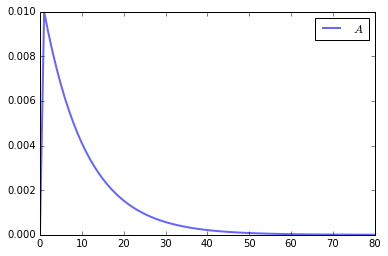

In [16]:
fig, plot_A_const = plt.subplots()
x = np.linspace(0, 80, 81)
plot_A_const.plot(x, rbc.irs['e_A']['A']/rbc.ss.A, linewidth=2, linestyle='solid', alpha=0.6, label='$A$')
plot_A_const.legend()
plt.savefig('plot_A_const.png')


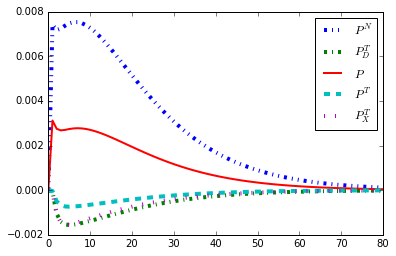

In [17]:
fig, PC_plot_P_GHH_const = plt.subplots()
PC_plot_P_GHH_const.plot(x, rbc.irs['e_A']['P_N']/rbc.ss.P_N, linewidth=4, linestyle=(0, (3, 5, 1, 5, 1, 5)), alpha=1, label='$P^N$')
PC_plot_P_GHH_const.plot(x, rbc.irs['e_A']['P_TD']/rbc.ss.P_TD, linewidth=4, linestyle='dashdot', alpha=1, label='$P^T_D$')
PC_plot_P_GHH_const.plot(x, rbc.irs['e_A']['P']/rbc.ss.P, linewidth=2, linestyle='solid', alpha=1, label='$P$')
PC_plot_P_GHH_const.plot(x, rbc.irs['e_A']['P_T']/rbc.ss.P_T, linewidth=4, linestyle='dashed', alpha=1, label='$P^T$')
PC_plot_P_GHH_const.plot(x, rbc.irs['e_A']['P_x']/rbc.ss.P_x, linewidth=4, linestyle=(0, (1, 10)), alpha=1, label='$P_X^T$')
PC_plot_P_GHH_const.legend(loc='upper right')
plt.savefig('PC_plot_P_GHH_const.png')

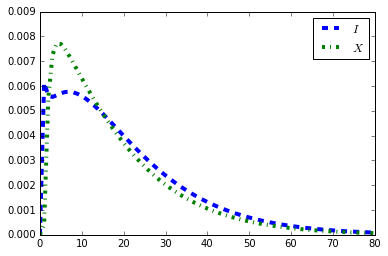

In [18]:
fig, PC_plot_NXIX_GHH_const = plt.subplots()
PC_plot_NXIX_GHH_const.plot(x, rbc.irs['e_A']['I']/rbc.ss.I, linewidth=4, linestyle='dashed', alpha=1, label='$I$')
PC_plot_NXIX_GHH_const.plot(x, rbc.irs['e_A']['X']/rbc.ss.X, linewidth=4, linestyle='dashdot', alpha=1, label='$X$')
PC_plot_NXIX_GHH_const.legend()
axes = plt.gca()
axes.set_ylim([0,0.009])
plt.savefig('PC_plot_NXIX_GHH_const.png')

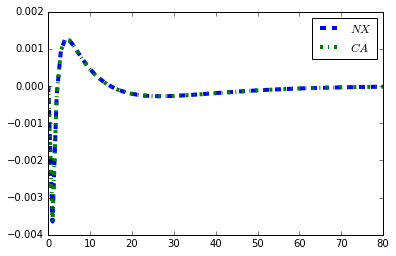

In [17]:
fig, PC_plot_check = plt.subplots()
PC_plot_check.plot(x, rbc.irs['e_A']['NX'], linewidth=4, linestyle='dashed', alpha=1, label='$NX$')
PC_plot_check.plot(x, rbc.irs['e_A']['CA'], linewidth=4, linestyle='dashdot', alpha=1, label='$CA$')
plot_check.legend()

In [23]:
fig, PC_plot_macro_GHH_const = plt.subplots()
PC_plot_macro_GHH_const.plot(x, rbc.irs['e_A']['C']/rbc.ss.C, linewidth=4, linestyle='dashed', alpha=1, label='$C$')
PC_plot_macro_GHH_const.plot(x, rbc.irs['e_A']['B']/rbc.ss.B, linewidth=4, linestyle='dashdot', alpha=1, label='$B$')
PC_plot_macro_GHH_const.plot(x, rbc.irs['e_A']['GDP']/rbc.ss.GDP, linewidth=2, linestyle='solid', alpha=1, label='$GDP$')
PC_plot_macro_GHH_const.legend(loc='lower right')
plt.savefig('PC_plot_macro_GHH_const.png')

In [24]:
fig, PC_plot_d_GHH_const = plt.subplots()
PC_plot_d_GHH_const.plot(x, rbc.irs['e_A']['d_tilde']/rbc.ss.d_tilde, linewidth=4, linestyle='dashed', alpha=1, label=r'$\tilde{\pi}$')
PC_plot_d_GHH_const.plot(x, rbc.irs['e_A']['d_tilde_x']/rbc.ss.d_tilde_x, linewidth=4, linestyle='dashdot', alpha=1, label=r'$\tilde{\pi}_X$')
PC_plot_d_GHH_const.plot(x, rbc.irs['e_A']['d_tilde_d']/rbc.ss.d_tilde_d, linewidth=2, linestyle='solid', alpha=1, label=r'$\tilde{\pi}_D$')
PC_plot_d_GHH_const.legend(loc='upper right')
plt.savefig('PC_plot_d_GHH_const.png')

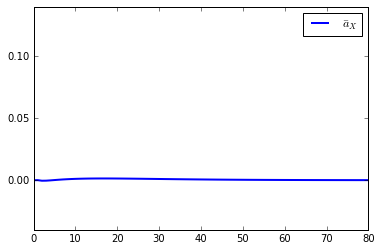

In [20]:
fig, plot_abar_const = plt.subplots()
plot_abar_const.plot(x, rbc.irs['e_A']['a_bar_x'], linewidth=2, linestyle='solid', alpha=1, label=r'$\bar{a}_X$')
plot_abar_const.legend()
axes = plt.gca()
axes.set_ylim([-0.04,0.14])
plt.savefig('plot_abar_const.png')

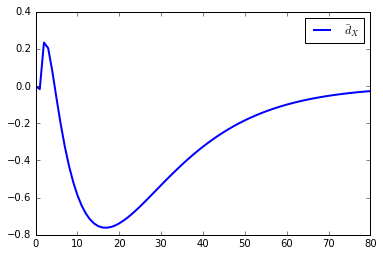

In [20]:
fig, plot_dbar_const = plt.subplots()
plot_dbar_const.plot(x, rbc.irs['e_A']['d_bar_x'], linewidth=2, linestyle='solid', alpha=1, label=r'$\bar{d}_X$')
plot_dbar_const.legend()
plt.savefig('plot_dbar_const.png')

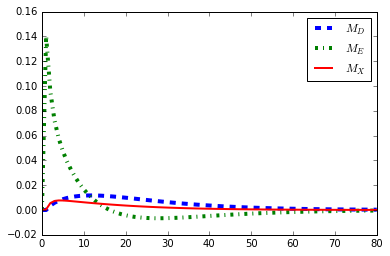

In [25]:
fig, PC_plot_M_GHH_const = plt.subplots()
PC_plot_M_GHH_const.plot(x, rbc.irs['e_A']['M_d']/rbc.ss.M_d, linewidth=4, linestyle='dashed', alpha=1, label=r'$M_D$')
PC_plot_M_GHH_const.plot(x, rbc.irs['e_A']['M_e']/rbc.ss.M_e, linewidth=4, linestyle='dashdot', alpha=1, label=r'$M_E$')
PC_plot_M_GHH_const.plot(x, rbc.irs['e_A']['M_x']/rbc.ss.M_x, linewidth=2, linestyle='solid', alpha=1, label=r'$M_X$')
PC_plot_M_GHH_const.legend()
plt.savefig('PC_plot_M_GHH_const.png')

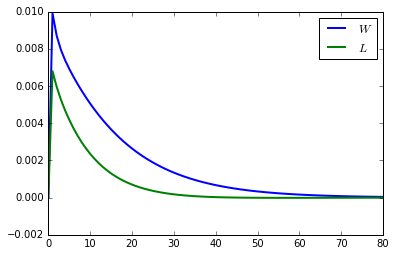

In [19]:
fig, PC_plot_W_GHH_const = plt.subplots()
PC_plot_W_GHH_const.plot(x, rbc.irs['e_A']['W']/rbc.ss.W, linewidth=2, linestyle='solid', alpha=1, label=r'$W$')
PC_plot_W_GHH_const.plot(x, rbc.irs['e_A']['L']/rbc.ss.L, linewidth=2, linestyle='solid', alpha=1, label=r'$L$')
PC_plot_W_GHH_const.legend()
plt.savefig('PC_plot_W_GHH_const.png')

In [29]:
fig, PC_plot_L_GHH_const = plt.subplots()
PC_plot_L_GHH_const.plot(x, rbc.irs['e_A']['L']/rbc.ss.L, linewidth=2, linestyle='solid', alpha=1, label=r'$L$')
PC_plot_L_GHH_const.legend()
plt.savefig('PC_plot_L_GHH_const.png')

In [19]:
df_EC_Llambda_const = pd.read_csv (r'PC_GHH_EC_Llambda_const.csv', header=0)
df_EC_Hlambda_const = pd.read_csv (r'PC_GHH_EC_Hlambda_const.csv', header=0)
df_EC_2_const = pd.read_csv (r'PC_GHH_EC2_const.csv', header=0)
df_EC_3_const = pd.read_csv (r'PC_GHH_EC3_const.csv', header=0)

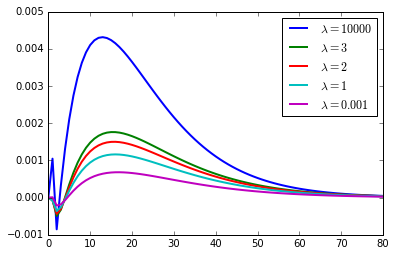

In [20]:
fig, PC_plot_EC_GHH_const = plt.subplots()
PC_plot_EC_GHH_const.plot(x, df_EC_Llambda_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=10000$')
PC_plot_EC_GHH_const.plot(x, df_EC_3_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=3$')
PC_plot_EC_GHH_const.plot(x, df_EC_2_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=2$')
PC_plot_EC_GHH_const.plot(x, rbc.irs['e_A']['EC']/rbc.ss.EC, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=1$')
PC_plot_EC_GHH_const.plot(x, df_EC_Hlambda_const, linewidth=2, linestyle='solid', alpha=1, label=r'$\lambda=0.001$')
PC_plot_EC_GHH_const.legend()
plt.savefig('PC_plot_EC_GHH_const.png')


In [30]:
#save responses
rbc.irs['e_A']['exprof']
np.savetxt("GDP_exprof_GHH_const.csv", rbc.irs['e_A']['exprof']/rbc.ss.GDP, delimiter=",", header='1')

rbc.irs['e_A']['EM']
np.savetxt("EM_GHH_const.csv", rbc.irs['e_A']['EM'], delimiter=",", header='1')

rbc.irs['e_A']['d_bar_x']
np.savetxt("GDP_IM_GHH_const.csv", rbc.irs['e_A']['d_bar_x']/rbc.ss.GDP, delimiter=",", header='1')

rbc.irs['e_A']['a_tilde_x']
np.savetxt("GDP_SE_GHH_const.csv", rbc.irs['e_A']['a_tilde_x']/1.217, delimiter=",", header='1')

In [31]:
rbc.irs['e_A']['exprof']
np.savetxt("PC_exprof_GHH_const.csv", rbc.irs['e_A']['exprof']/rbc.ss.exprof, delimiter=",", header='1')

rbc.irs['e_A']['EM']
np.savetxt("PC_EM_GHH_const.csv", rbc.irs['e_A']['EM']/rbc.ss.EM, delimiter=",", header='1')

rbc.irs['e_A']['d_bar_x']
np.savetxt("PC_IM_GHH_const.csv", rbc.irs['e_A']['d_bar_x']/rbc.ss.d_bar_x, delimiter=",", header='1')

rbc.irs['e_A']['a_tilde_x']
np.savetxt("PC_SE_GHH_const.csv", rbc.irs['e_A']['a_tilde_x']/rbc.ss.a_tilde_x, delimiter=",", header='1')

In [32]:
rbc.irs['e_A']['P_x']
np.savetxt("PC_P_x_GHH_const.csv", rbc.irs['e_A']['P_x']/rbc.ss.P_x, delimiter=",", header='1')

rbc.irs['e_A']['X']
np.savetxt("PC_X_GHH_const.csv", rbc.irs['e_A']['X']/rbc.ss.X, delimiter=",", header='1')

rbc.irs['e_A']['GDP']
np.savetxt("PC_GDP_GHH_const.csv", rbc.irs['e_A']['GDP']/rbc.ss.GDP, delimiter=",", header='1')

rbc.irs['e_A']['M_d']
np.savetxt("PC_M_d_GHH_const.csv", rbc.irs['e_A']['M_d']/rbc.ss.M_d, delimiter=",", header='1')

rbc.irs['e_A']['d_tilde']
np.savetxt("PC_d_tilde_GHH_const.csv", rbc.irs['e_A']['d_tilde']/rbc.ss.d_tilde, delimiter=",", header='1')

rbc.irs['e_A']['W']
np.savetxt("PC_W_GHH_const.csv", rbc.irs['e_A']['W']/rbc.ss.W, delimiter=",", header='1')

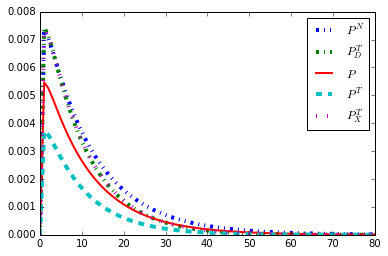

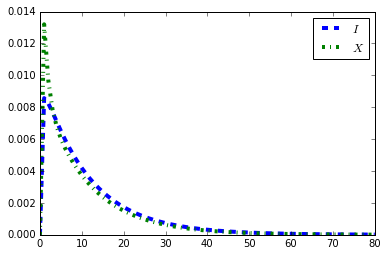

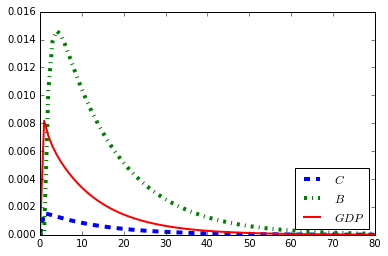

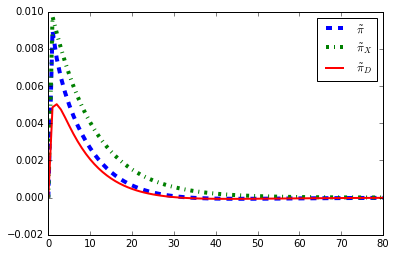

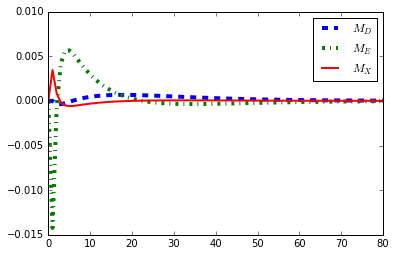

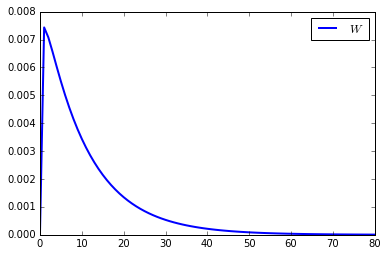

In [21]:
fig, Pstar_PC_plot_P_const = plt.subplots()
Pstar_PC_plot_P_const.plot(x, rbc.irs['e_P_star']['P_N']/rbc.ss.P_N, linewidth=4, linestyle=(0, (3, 5, 1, 5, 1, 5)), alpha=1, label='$P^N$')
Pstar_PC_plot_P_const.plot(x, rbc.irs['e_P_star']['P_TD']/rbc.ss.P_TD, linewidth=4, linestyle='dashdot', alpha=1, label='$P^T_D$')
Pstar_PC_plot_P_const.plot(x, rbc.irs['e_P_star']['P']/rbc.ss.P, linewidth=2, linestyle='solid', alpha=1, label='$P$')
Pstar_PC_plot_P_const.plot(x, rbc.irs['e_P_star']['P_T']/rbc.ss.P_T, linewidth=4, linestyle='dashed', alpha=1, label='$P^T$')
Pstar_PC_plot_P_const.plot(x, rbc.irs['e_P_star']['P_x']/rbc.ss.P_x, linewidth=4, linestyle=(0, (1, 10)), alpha=1, label='$P_X^T$')
Pstar_PC_plot_P_const.legend(loc='upper right')
plt.savefig('Pstar_PC_plot_P_const.png')

fig, Pstar_PC_plot_NXIX_const = plt.subplots()
Pstar_PC_plot_NXIX_const.plot(x, rbc.irs['e_P_star']['I']/rbc.ss.I, linewidth=4, linestyle='dashed', alpha=1, label='$I$')
Pstar_PC_plot_NXIX_const.plot(x, rbc.irs['e_P_star']['X']/rbc.ss.X, linewidth=4, linestyle='dashdot', alpha=1, label='$X$')
Pstar_PC_plot_NXIX_const.legend()
plt.savefig('Pstar_PC_plot_NXIX_const.png')

fig, Pstar_PC_plot_macro_const = plt.subplots()
Pstar_PC_plot_macro_const.plot(x, rbc.irs['e_P_star']['C']/rbc.ss.C, linewidth=4, linestyle='dashed', alpha=1, label='$C$')
Pstar_PC_plot_macro_const.plot(x, rbc.irs['e_P_star']['B']/rbc.ss.B, linewidth=4, linestyle='dashdot', alpha=1, label='$B$')
Pstar_PC_plot_macro_const.plot(x, rbc.irs['e_P_star']['GDP']/rbc.ss.GDP, linewidth=2, linestyle='solid', alpha=1, label='$GDP$')
Pstar_PC_plot_macro_const.legend(loc='lower right')
plt.savefig('Pstar_PC_plot_macro_const.png')

fig, Pstar_PC_plot_d_const = plt.subplots()
Pstar_PC_plot_d_const.plot(x, rbc.irs['e_P_star']['d_tilde']/rbc.ss.d_tilde, linewidth=4, linestyle='dashed', alpha=1, label=r'$\tilde{\pi}$')
Pstar_PC_plot_d_const.plot(x, rbc.irs['e_P_star']['d_tilde_x']/rbc.ss.d_tilde_x, linewidth=4, linestyle='dashdot', alpha=1, label=r'$\tilde{\pi}_X$')
Pstar_PC_plot_d_const.plot(x, rbc.irs['e_P_star']['d_tilde_d']/rbc.ss.d_tilde_d, linewidth=2, linestyle='solid', alpha=1, label=r'$\tilde{\pi}_D$')
Pstar_PC_plot_d_const.legend(loc='upper right')
plt.savefig('Pstar_PC_plot_d_const.png')

fig, Pstar_PC_plot_M_const = plt.subplots()
Pstar_PC_plot_M_const.plot(x, rbc.irs['e_P_star']['M_d']/rbc.ss.M_d, linewidth=4, linestyle='dashed', alpha=1, label=r'$M_D$')
Pstar_PC_plot_M_const.plot(x, rbc.irs['e_P_star']['M_e']/rbc.ss.M_e, linewidth=4, linestyle='dashdot', alpha=1, label=r'$M_E$')
Pstar_PC_plot_M_const.plot(x, rbc.irs['e_P_star']['M_x']/rbc.ss.M_x, linewidth=2, linestyle='solid', alpha=1, label=r'$M_X$')
Pstar_PC_plot_M_const.legend()
plt.savefig('Pstar_PC_plot_M_const.png')

fig, Pstar_PC_plot_W_const = plt.subplots()
Pstar_PC_plot_W_const.plot(x, rbc.irs['e_P_star']['W']/rbc.ss.W, linewidth=2, linestyle='solid', alpha=1, label=r'$W$')
Pstar_PC_plot_W_const.legend()
plt.savefig('Pstar_PC_plot_W_const.png')


In [22]:
#save responses
rbc.irs['e_P_star']['exprof']
np.savetxt("Pstar_GDP_exprof_const.csv", rbc.irs['e_P_star']['exprof']/rbc.ss.GDP, delimiter=",", header='1')

rbc.irs['e_P_star']['EM']
np.savetxt("Pstar_EM_const.csv", rbc.irs['e_P_star']['EM'], delimiter=",", header='1')

rbc.irs['e_P_star']['d_bar_x']
np.savetxt("Pstar_GDP_IM_const.csv", rbc.irs['e_P_star']['d_bar_x']/rbc.ss.GDP, delimiter=",", header='1')

rbc.irs['e_P_star']['a_tilde_x']
np.savetxt("Pstar_GDP_SE_const.csv", rbc.irs['e_P_star']['a_tilde_x']/1.217, delimiter=",", header='1')

In [23]:
rbc.irs['e_P_star']['exprof']
np.savetxt("Pstar_PC_exprof_const.csv", rbc.irs['e_P_star']['exprof']/rbc.ss.exprof, delimiter=",", header='1')

rbc.irs['e_P_star']['EM']
np.savetxt("Pstar_PC_EM_const.csv", rbc.irs['e_P_star']['EM']/rbc.ss.EM, delimiter=",", header='1')

rbc.irs['e_P_star']['d_bar_x']
np.savetxt("Pstar_PC_IM_const.csv", rbc.irs['e_P_star']['d_bar_x']/rbc.ss.d_bar_x, delimiter=",", header='1')

rbc.irs['e_P_star']['a_tilde_x']
np.savetxt("Pstar_PC_SE_const.csv", rbc.irs['e_P_star']['a_tilde_x']/rbc.ss.a_tilde_x, delimiter=",", header='1')

In [24]:
rbc.irs['e_P_star']['P_x']
np.savetxt("Pstar_PC_P_x_const.csv", rbc.irs['e_P_star']['P_x']/rbc.ss.P_x, delimiter=",", header='1')

rbc.irs['e_P_star']['X']
np.savetxt("Pstar_PC_X_const.csv", rbc.irs['e_P_star']['X']/rbc.ss.X, delimiter=",", header='1')

rbc.irs['e_P_star']['GDP']
np.savetxt("Pstar_PC_GDP_const.csv", rbc.irs['e_P_star']['GDP']/rbc.ss.GDP, delimiter=",", header='1')

rbc.irs['e_P_star']['M_d']
np.savetxt("Pstar_PC_M_d_const.csv", rbc.irs['e_P_star']['M_d']/rbc.ss.M_d, delimiter=",", header='1')

rbc.irs['e_P_star']['d_tilde']
np.savetxt("Pstar_PC_d_tilde_const.csv", rbc.irs['e_P_star']['d_tilde']/rbc.ss.d_tilde, delimiter=",", header='1')

rbc.irs['e_P_star']['W']
np.savetxt("Pstar_PC_W_const.csv", rbc.irs['e_P_star']['W']/rbc.ss.W, delimiter=",", header='1')

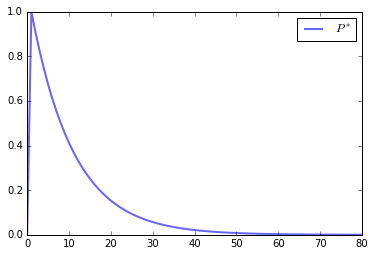

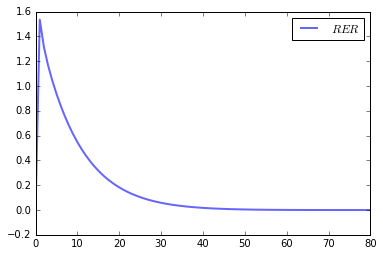

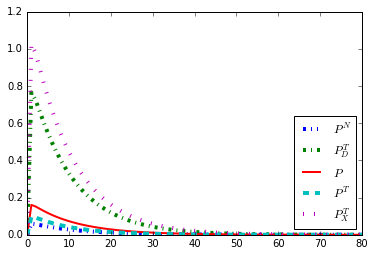

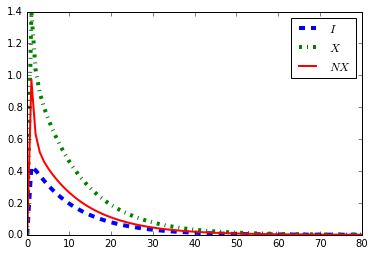

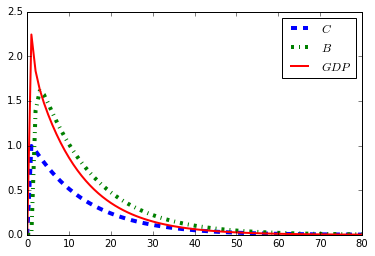

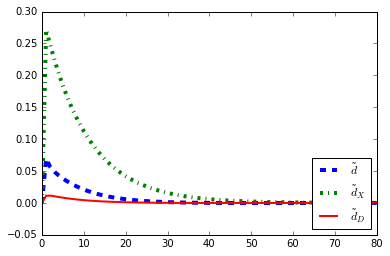

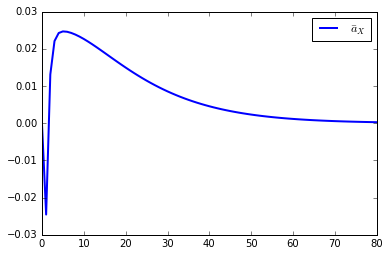

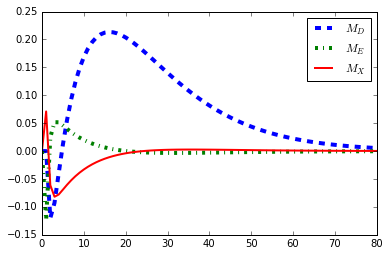

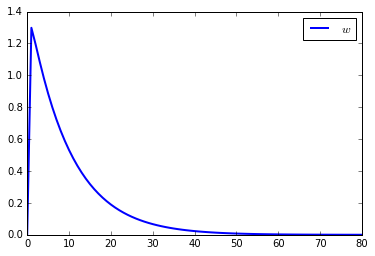

In [16]:
fig, plot_Pstar_Pstar = plt.subplots()
x = np.linspace(0, 80, 81)
plot_Pstar_Pstar.plot(x, rbc.irs['e_P_star']['P_star'], linewidth=2, linestyle='solid', alpha=0.6, label=r'$P^*$')
plot_Pstar_Pstar.legend()
plt.savefig('plot_Pstar_Pstar.png')

fig, plot_RER_Pstar = plt.subplots()
plot_RER_Pstar.plot(x, rbc.irs['e_P_star']['RER'], linewidth=2, linestyle='solid', alpha=0.6, label=r'$RER$')
plot_RER_Pstar.legend()
plt.savefig('plot_RER_Pstar.png')

fig, plot_P_Pstar = plt.subplots()
plot_P_Pstar.plot(x, rbc.irs['e_P_star']['P_N'], linewidth=4, linestyle=(0, (3, 5, 1, 5, 1, 5)), alpha=1, label='$P^N$')
plot_P_Pstar.plot(x, rbc.irs['e_P_star']['P_TD'], linewidth=4, linestyle='dashdot', alpha=1, label='$P^T_D$')
plot_P_Pstar.plot(x, rbc.irs['e_P_star']['P'], linewidth=2, linestyle='solid', alpha=1, label='$P$')
plot_P_Pstar.plot(x, rbc.irs['e_P_star']['P_T'], linewidth=4, linestyle='dashed', alpha=1, label='$P^T$')
plot_P_Pstar.plot(x, rbc.irs['e_P_star']['P_x'], linewidth=4, linestyle=(0, (1, 10)), alpha=1, label='$P_X^T$')
plot_P_Pstar.legend(loc='lower right')
plt.savefig('plot_P_Pstar.png')

fig, plot_NX_Pstar = plt.subplots()
plot_NX_Pstar.plot(x, rbc.irs['e_P_star']['I'], linewidth=4, linestyle='dashed', alpha=1, label='$I$')
plot_NX_Pstar.plot(x, rbc.irs['e_P_star']['X'], linewidth=4, linestyle='dashdot', alpha=1, label='$X$')
plot_NX_Pstar.plot(x, rbc.irs['e_P_star']['NX'], linewidth=2, linestyle='solid', alpha=1, label='$NX$')
plot_NX_Pstar.legend()
plt.savefig('plot_NX_Pstar.png')

fig, plot_macro_Pstar = plt.subplots()
plot_macro_Pstar.plot(x, rbc.irs['e_P_star']['C'], linewidth=4, linestyle='dashed', alpha=1, label='$C$')
plot_macro_Pstar.plot(x, rbc.irs['e_P_star']['B'], linewidth=4, linestyle='dashdot', alpha=1, label='$B$')
plot_macro_Pstar.plot(x, rbc.irs['e_P_star']['GDP'], linewidth=2, linestyle='solid', alpha=1, label='$GDP$')
plot_macro_Pstar.legend()
plt.savefig('plot_macro_Pstar.png')

fig, plot_d_P_star = plt.subplots()
plot_d_P_star.plot(x, rbc.irs['e_P_star']['d_tilde'], linewidth=4, linestyle='dashed', alpha=1, label=r'$\tilde{d}$')
plot_d_P_star.plot(x, rbc.irs['e_P_star']['d_tilde_x'], linewidth=4, linestyle='dashdot', alpha=1, label=r'$\tilde{d}_X$')
plot_d_P_star.plot(x, rbc.irs['e_P_star']['d_tilde_d'], linewidth=2, linestyle='solid', alpha=1, label=r'$\tilde{d}_D$')
plot_d_P_star.legend(loc='lower right')
plt.savefig('plot_d_P_star.png')

fig, plot_abar_Pstar = plt.subplots()
plot_abar_Pstar.plot(x, rbc.irs['e_P_star']['a_bar_x'], linewidth=2, linestyle='solid', alpha=1, label=r'$\bar{a}_X$')
plot_abar_Pstar.legend()
plt.savefig('plot_abar_Pstar.png')

fig, plot_M_Pstar = plt.subplots()
plot_M_Pstar.plot(x, rbc.irs['e_P_star']['M_d'], linewidth=4, linestyle='dashed', alpha=1, label=r'$M_D$')
plot_M_Pstar.plot(x, rbc.irs['e_P_star']['M_e'], linewidth=4, linestyle='dashdot', alpha=1, label=r'$M_E$')
plot_M_Pstar.plot(x, rbc.irs['e_P_star']['M_x'], linewidth=2, linestyle='solid', alpha=1, label=r'$M_X$')
plot_M_Pstar.legend()
plt.savefig('plot_M_Pstar.png')

fig, plot_w_Pstar = plt.subplots()
plot_w_Pstar.plot(x, rbc.irs['e_P_star']['w'], linewidth=2, linestyle='solid', alpha=1, label=r'$w$')
plot_w_Pstar.legend()
plt.savefig('plot_w_Pstar.png')